# Content-based Movie Recommender

In [1]:
%pylab inline

import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


In [324]:
# Imports
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.linear_model import LinearRegression

## Load the MovieLens data

You can download the file `ml_latest.zip`[here](https://grouplens.org/datasets/movielens/) and then unzip into the `data/` directory.

In [3]:
!ls data/

genome-scores.csv links.csv         ratings.csv
genome-tags.csv   movies.csv


In [4]:
# Read dataframes
df_movies = pd.read_csv('data/movies.csv')
df_ratings = pd.read_csv('data/ratings.csv')
df_genome_tags = pd.read_csv('data/genome-tags.csv')
df_genome_scores = pd.read_csv('data/genome-scores.csv')

# Merge scores and tags
df_movie_tags_in_text = pd.merge(df_genome_scores, df_genome_tags, on='tagId')[['movieId', 'tag', 'relevance']]

# Only keep tags with relevance higher than 0.3
df_movie_tags = df_genome_scores[df_genome_scores.relevance > 0.3][['movieId', 'tagId']]

### Which is movie with Id 1?

In [5]:
df_movies[df_movies.movieId == 1]

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


### Let's have a look at a few of the tags Toy Story 

In [358]:
df_movie_tags[df_movie_tags['movieId'] == 1].merge(df_genome_tags, on='tagId').sample(10)

,movieId,tagId,tag
155,1,999,suspense
95,1,548,inspirational
173,1,1092,visually stunning
65,1,387,feel good movie
7,1,49,alter ego
137,1,889,science fiction
163,1,1036,toys
8,1,61,animal movie
103,1,610,loneliness
99,1,588,kids


## One-hot-encoding

In [423]:
A = [[1,0,1,0]]
B = [[1,0,0,0]]
D = [[0,1,0,1]]

In [424]:
cosine_similarity(A,B)

array([[0.70710678]])

In [425]:
cosine_similarity(A,D)

array([[0.]])

### Encode features

In [7]:
df_tags_to_movies = pd.merge(df_movie_tags, df_genome_tags, on='tagId', how='left')[['movieId', 'tagId']]
df_tags_to_movies['tagId'] = df_tags_to_movies.tagId.astype(str)

In [8]:
def _concatenate_tags_of_movie(tags):
    tags_as_str = ' '.join(set(tags))
    return tags_as_str

In [9]:
df_tags_per_movie = df_tags_to_movies.groupby('movieId')['tagId'].agg(_concatenate_tags_of_movie)
df_tags_per_movie.name = 'movie_tags'
df_tags_per_movie = df_tags_per_movie.reset_index()

In [10]:
df_tags_per_movie[df_tags_per_movie['movieId'] == 1]

,movieId,movie_tags
0,1,216 623 215 669 760 664 497 490 691 21 1072 29...


In [11]:
df_avg_ratings  = df_ratings.groupby('movieId')['rating'].agg(['mean', 'median', 'size'])
df_avg_ratings.columns = ['rating_mean', 'rating_median', 'num_ratingsdf_tags_per_movie']
df_avg_ratings = df_avg_ratings.reset_index()

In [12]:
df_movies_with_ratings = pd.merge(df_movies, df_avg_ratings, how='left', on='movieId')

In [13]:
df_data = pd.merge(df_movies_with_ratings, df_tags_per_movie, how='left', on='movieId')

In [14]:
df_data_with_tags = df_data[~df_data.movie_tags.isnull()].reset_index(drop=True)

### TF-IDF vectors

In [15]:
tf_idf = TfidfVectorizer()

In [395]:
tf_idf.get_feature_names()[883]

u'785'

In [16]:
df_movies_tf_idf_described = tf_idf.fit_transform(df_data_with_tags.movie_tags)

In [403]:
m2m = cosine_similarity(df_movies_tf_idf_described)

In [18]:
df_tfidf_m2m = pd.DataFrame(cosine_similarity(df_movies_tf_idf_described))

In [19]:
index_to_movie_id = df_data_with_tags['movieId']

In [20]:
df_tfidf_m2m.columns = [str(index_to_movie_id[int(col)]) for col in df_tfidf_m2m.columns]

In [21]:
df_tfidf_m2m.index = [index_to_movie_id[idx] for idx in df_tfidf_m2m.index]

### Most similar movies to Toy Story

In [23]:
df_tfidf_m2m.iloc[0].sort_values(ascending=False)[:10]

1        1.000000
3114     0.737982
4886     0.736047
2355     0.721830
78499    0.708378
76093    0.685637
5218     0.653424
4306     0.642794
6377     0.639971
68954    0.635059
Name: 1, dtype: float64

In [24]:
df_data_with_tags[df_data_with_tags.movieId == 3114]

,movieId,title,genres,rating_mean,rating_median,num_ratingsdf_tags_per_movie,movie_tags
2769,3114,Toy Story 2 (1999),Adventure|Animation|Children|Comedy|Fantasy,3.811412,4.0,7352.0,215 669 664 496 138 490 1072 29 1070 1071 406 ...


In [25]:
df_data_with_tags[df_data_with_tags.movieId == 4886]

,movieId,title,genres,rating_mean,rating_median,num_ratingsdf_tags_per_movie,movie_tags
4331,4886,"Monsters, Inc. (2001)",Adventure|Animation|Children|Comedy|Fantasy,3.861679,4.0,8708.0,216 215 669 664 663 765 136 497 490 493 690 10...


In [329]:
df_data_with_tags[df_data_with_tags.movieId == 2355]

,movieId,title,genres,rating_mean,rating_median,num_ratingsdf_tags_per_movie,movie_tags
2064,2355,"Bug's Life, A (1998)",Adventure|Animation|Children|Comedy,3.586201,4.0,6334.0,215 213 664 136 497 490 493 20 21 1072 29 1070...


### Cosine Similarity for Terminator 2

The costine similarity between Toy Story 2 and Terminator 2

In [26]:
df_data_with_tags[df_data_with_tags.title.str.contains('Terminator 2')]

,movieId,title,genres,rating_mean,rating_median,num_ratingsdf_tags_per_movie,movie_tags
555,589,Terminator 2: Judgment Day (1991),Action|Sci-Fi,3.947648,4.0,16093.0,216 768 215 212 1085 668 452 761 663 767 132 8...


In [27]:
df_tfidf_m2m.iloc[1][555]

0.2831101645346708

### Model user profiles

In [40]:
model = LinearRegression()

In [325]:
df_rating_counts = df_ratings['userId'].value_counts()
df_rating_counts = df_rating_counts[df_rating_counts.between(100, 300)]
df_ratings.set_index('userId').loc[df_rating_counts.index]
df_ratings_2 = df_ratings.set_index('userId').loc[df_rating_counts.index].reset_index()
df_ratings_3 = df_ratings_2.merge(df_data_with_tags.reset_index()[['index', 'movieId']], on='movieId')

In [326]:
userIds = df_ratings_3['userId'].unique()

In [336]:
userId = 36770

precision_scores = []
recall_scores = []

userIds = df_ratings_3.userId.unique()

for userId in userIds[:100]:

    df_user_ratings = df_ratings_3[df_ratings_3['userId'] == userId]

    y = df_user_ratings['rating']

    X = []
    for i in df_user_ratings['index']:
        X.append(df_movies_tf_idf_described[i].todense())
    X = vstack(X)

    ids = range(len(y))

    X_train, X_test, y_train, y_test, id_train, id_test = train_test_split(X, y, ids)

    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    df_user_ratings_test = df_user_ratings.iloc[id_test]
    df_user_ratings_test['score'] = y_pred
    df_user_ratings_test_top_10 = df_user_ratings_test.sort_values('score', ascending=False).head(10)
    y_true = df_user_ratings_test_top_10['rating'] >= 4
    y_pred = ones(len(y_true))
    precision_scores.append(precision_score(y_true, y_pred))

In [337]:
mean(precision_scores)

0.763

## Benchmark

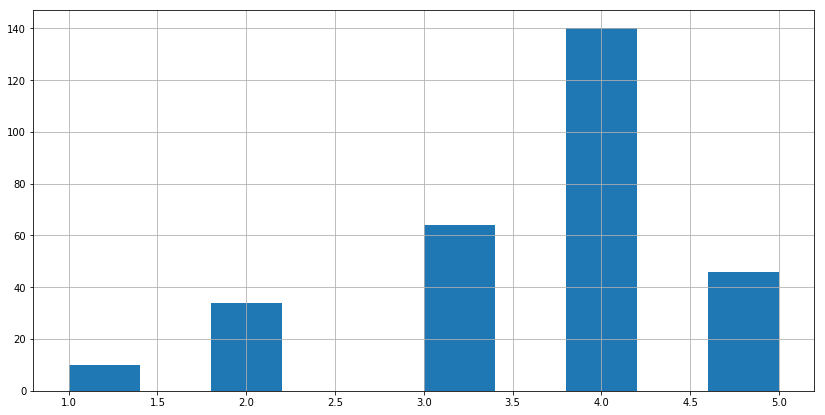

In [348]:
df_user_ratings['rating'].hist()

In [349]:
total_gt_4 = sum(df_ratings_3['rating'] >=4)

In [350]:
total_lt_4 = sum(df_ratings_3['rating'] < 4)

In [426]:
total_gt_4 * 1. /(total_gt_4 + total_lt_4)

0.5565561073218899

In [365]:
df = pd.read_csv('/Users/helge/Downloads/Lead list - Maker list.csv')

In [368]:
df['Maker type'].value_counts()

developer    52788
data          7644
product       3098
design        1644
Name: Maker type, dtype: int64